> This is a self-correcting activity generated by [nbgrader](https://nbgrader.readthedocs.io). Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Run subsequent cells to check your code.

---

# Forecast the weather

The goal of this activity is to analyze a times series with a Recurrent Neural Network (RNN), in order to forecast the weather based on past observations.

It uses a [weather dataset](https://www.bgc-jena.mpg.de/wetter/) recorded from 2003 to 2016 by the [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/) in Jena, Germany.

## Environment setup

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import os  # To access locally extracted file
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Python version: 3.8.3


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [22]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

from tensorflow.keras.utils import get_file

# You may add other imports here as needed
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU, Conv1D
from tensorflow.keras.optimizers import Adam

TensorFlow version: 2.3.1
Keras version: 2.4.0


In [4]:
# Utility functions


def plot_series(series, y_true, y_pred=None, x_label="$t$", y_label="$temp(t)$"):
    """Plot a time series with actual and predicted future values
    series: vector of shape (time steps, )
    y_true: scalar (if only 1 ahead step) or vector of shape (ahead steps,)
    y_pred: scalar (if only 1 ahead step) or vector of shape (ahead steps,)"""

    plt.plot(series, ".-")
    n_steps = series.shape[0]

    # Calculate the number of steps ahead (= number of future values)
    n_steps_ahead = 1
    if not np.isscalar(y_true):
        n_steps_ahead = y_true.shape[0]

    # Plot actual future values
    plt.plot(np.arange(n_steps, n_steps + n_steps_ahead), y_true, "ro-", label="Actual")

    if y_pred is not None:
        # Plot predicted future values
        plt.plot(
            np.arange(n_steps, n_steps + n_steps_ahead),
            y_pred,
            "bx-",
            label="Predicted",
            markersize=10,
        )
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=90)

    plt.legend(fontsize=14)


def plot_loss(history):
    """Plot training loss for a Keras model
    Takes a Keras History object as parameter"""

    loss = history.history["loss"]
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, ".--", label="Training loss")
    final_loss = loss[-1]
    title = "Training loss: {:.4f}".format(final_loss)
    plt.ylabel("Loss")
    if "val_loss" in history.history:
        val_loss = history.history["val_loss"]
        plt.plot(epochs, val_loss, "o-", label="Validation loss")
        final_val_loss = val_loss[-1]
        title += ", Validation loss: {:.4f}".format(final_val_loss)
    plt.title(title)
    plt.legend()

## Step 1: loading the data

In [5]:
# Download and extract the dataset
zip_path = get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True,
)
csv_path, _ = os.path.splitext(zip_path)
print(f"Dataset extracted at {csv_path}")

13574144/13568290 [==============================] - 6s 0us/step
Dataset extracted at /home/jchataigner/.keras/datasets/jena_climate_2009_2016.csv


In [6]:
# Load the dataset into a DataFrame
df_weather = pd.read_csv(csv_path)
print(f"Dataset: {df_weather.shape}")

Dataset: (420551, 15)


### Question

Show the first 10 data samples.

In [7]:
df_weather.head(n=10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


## Step 2: preparing the data

You'll try to predict the temperature by using only the past temperatures, and not the other features of the dataset.

In [8]:
# Select only the temperature feature in the dataset
df_univariate = df_weather["T (degC)"]

# Add time to ease visualization
df_univariate.index = df_weather["Date Time"]

df_univariate.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

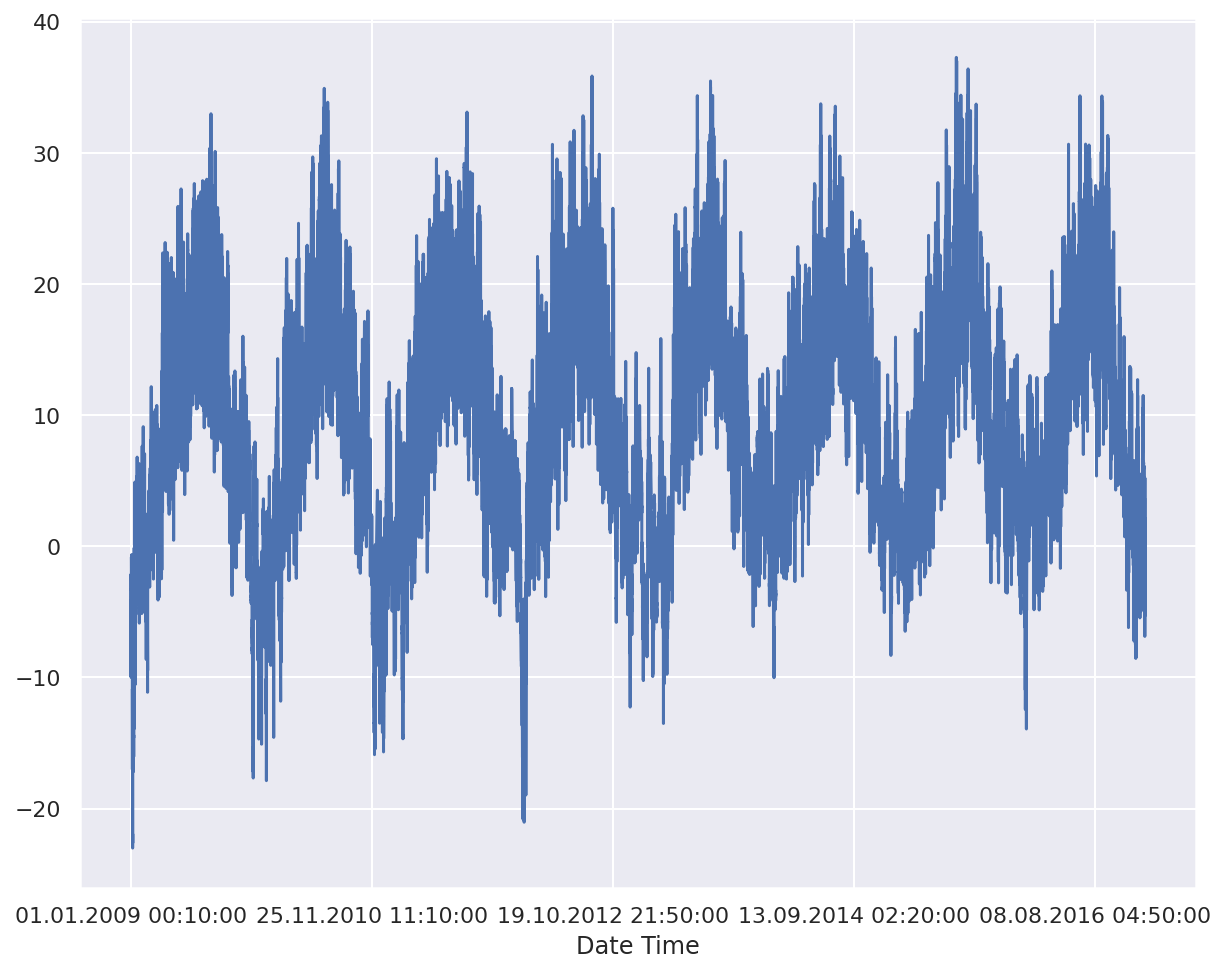

In [9]:
# Plot the temperatures over time
df_univariate.plot()
plt.show()

### Question

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.

Standardize the data using values computed on the training set.

In [15]:
# First 300,000 samples fo training
# Next 60,000 samples for validation
# Remaining samples for test
TRAIN_SPLIT = 300000
VAL_SPLIT = 360000

# Compute the mean and standard deviation on training set only
x_train_mean = df_univariate[:TRAIN_SPLIT].mean()
x_train_std = df_univariate[:TRAIN_SPLIT].std()

# Standardize the dataset
df_univariate = (df_univariate - x_train_mean) / x_train_std

df_univariate.head()

Date Time
01.01.2009 00:10:00   -1.997660
01.01.2009 00:20:00   -2.042816
01.01.2009 00:30:00   -2.054394
01.01.2009 00:40:00   -2.031237
01.01.2009 00:50:00   -2.026606
Name: T (degC), dtype: float64

### Creating inputs and targets

It's time to split the dataset as usual and create training, validation and test sets.

In [12]:
def prepare_univariate_data(dataset, start_index, end_index, history_size, target_size):
    """Create inputs and targets for a window of time defined by start_index and end_index
    history_size: number of time steps of the window
    target_size: number of steps ahead to be predicted"""

    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels).reshape(len(labels), 1)

In [13]:
# We're using the 20 last temperature observations to predict the next one.
past_history = 20
future_target = 0

x_train, y_train = prepare_univariate_data(
    df_univariate.values, 0, TRAIN_SPLIT, past_history, future_target,
)
x_val, y_val = prepare_univariate_data(
    df_univariate.values, TRAIN_SPLIT, VAL_SPLIT, past_history, future_target,
)
x_test, y_test = prepare_univariate_data(
    df_univariate.values, VAL_SPLIT, None, past_history, future_target,
)

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

x_train: (299980, 20, 1), y_train: (299980, 1)
x_val: (59980, 20, 1), y_val: (59980, 1)
x_test: (60531, 20, 1), y_test: (60531, 1)


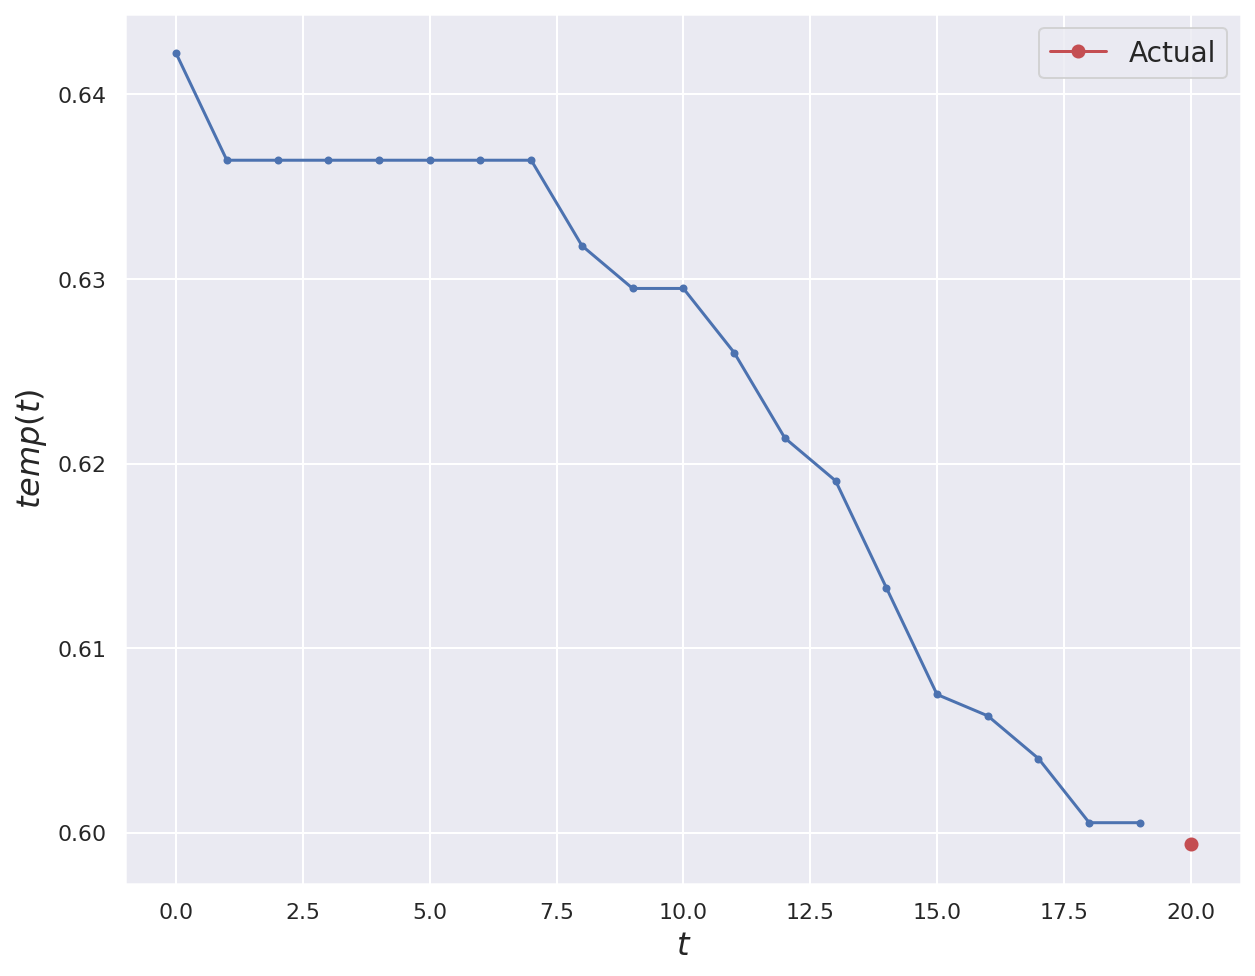

In [16]:
# Plot the first validation series with ground truth
plot_series(series=x_val[0, :, 0], y_true=y_val[0, 0])

## Step 3: training models

We start by defining a baseline model using a naïve approach, then try to beat it using a RNN.

In [20]:
# Baseline prediction = input for last time step
y_pred_baseline = x_val[:, -1]
print(f"y_pred_baseline: {y_pred_baseline.shape}")

baseline_mse = np.mean(mean_squared_error(y_val, y_pred_baseline))

# Print MSE
print(f"Baseline MSE: {baseline_mse:0.05f}")

y_pred_baseline: (59980, 1)
Baseline MSE: 0.00084


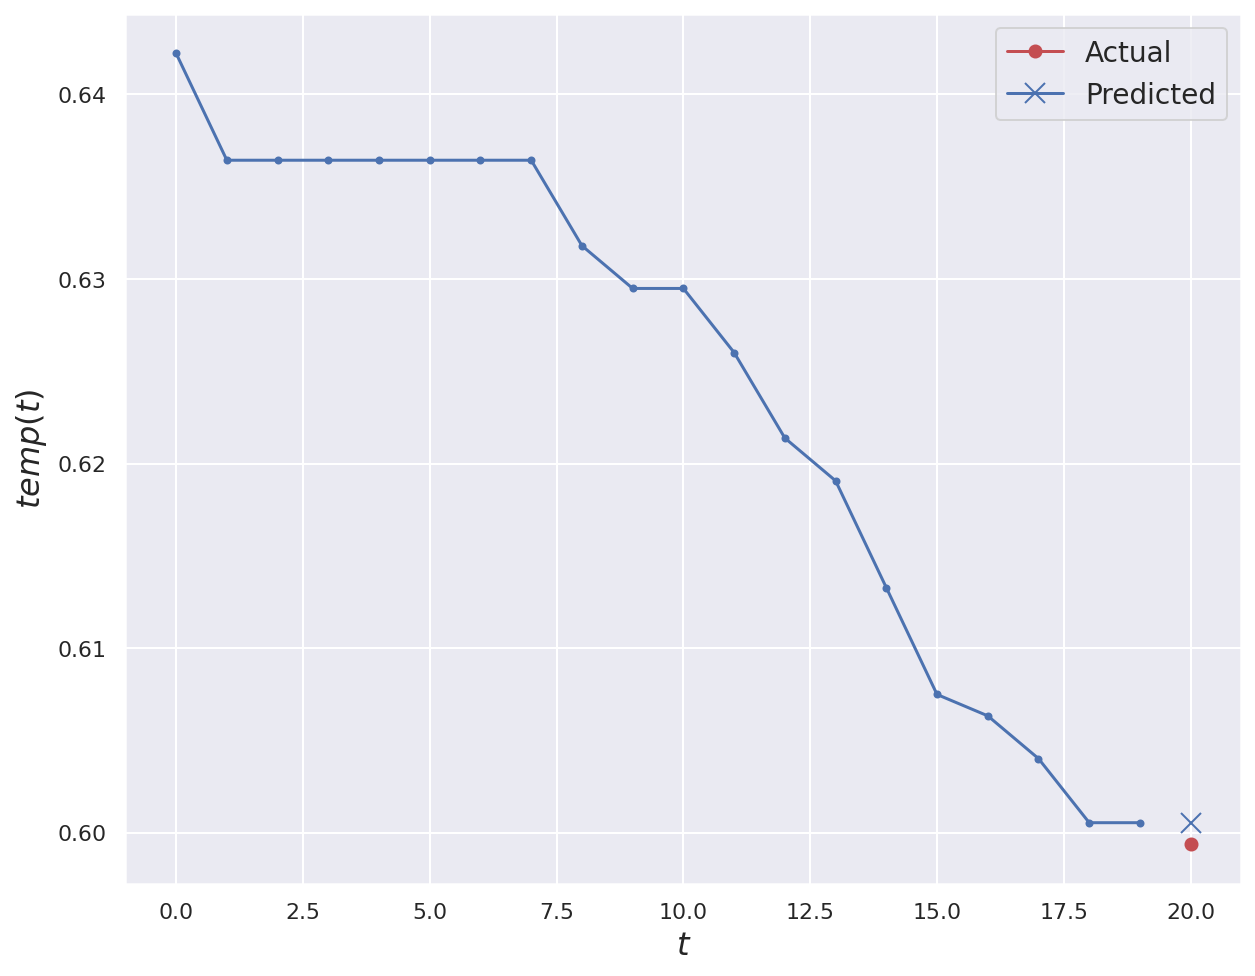

In [21]:
# Plot the first validation series with ground truth and prediction
plot_series(series=x_val[0, :, 0], y_true=y_val[0, 0], y_pred=y_pred_baseline[0, 0])

### Question

Define a Recurrent Neural Network model able to learn from the prepared data and predict the temperature one step ahead. Store it in the `univariate_model` variable.

In [28]:
# Create model

univariate_model = Sequential()

# 2 RNN layers
univariate_model.add(SimpleRNN(units=20, return_sequences=True, input_shape=(None, 1)))
univariate_model.add(SimpleRNN(units=20))

# 1 fully connected layer
univariate_model.add(Dense(units=1))

univariate_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


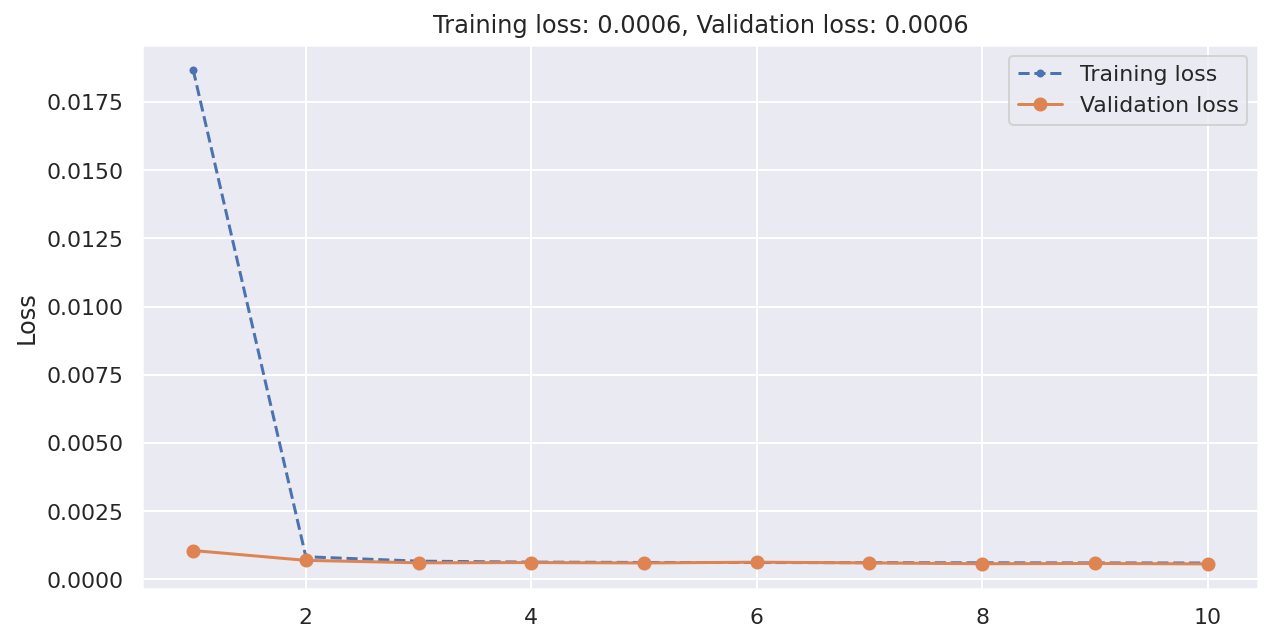

In [29]:
# Compile and traing the model

univariate_model.compile(optimizer="adam", loss="mse")

history = univariate_model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=256,
    verbose=0,
    validation_data=(x_val, y_val),
)

plot_loss(history)

### Question

Compute the model's prediction on validation data. Store the result in the `y_pred_univariate` variable.

The model's MSE must be lower than the baseline model's.

In [30]:
y_pred_univariate = univariate_model.predict(x_val)

In [31]:
univariate_mse = np.mean(mean_squared_error(y_val, y_pred_univariate))

# Print MSE
print(f"Univariate MSE: {univariate_mse:0.05f}")

assert univariate_mse < baseline_mse

Univariate MSE: 0.00057


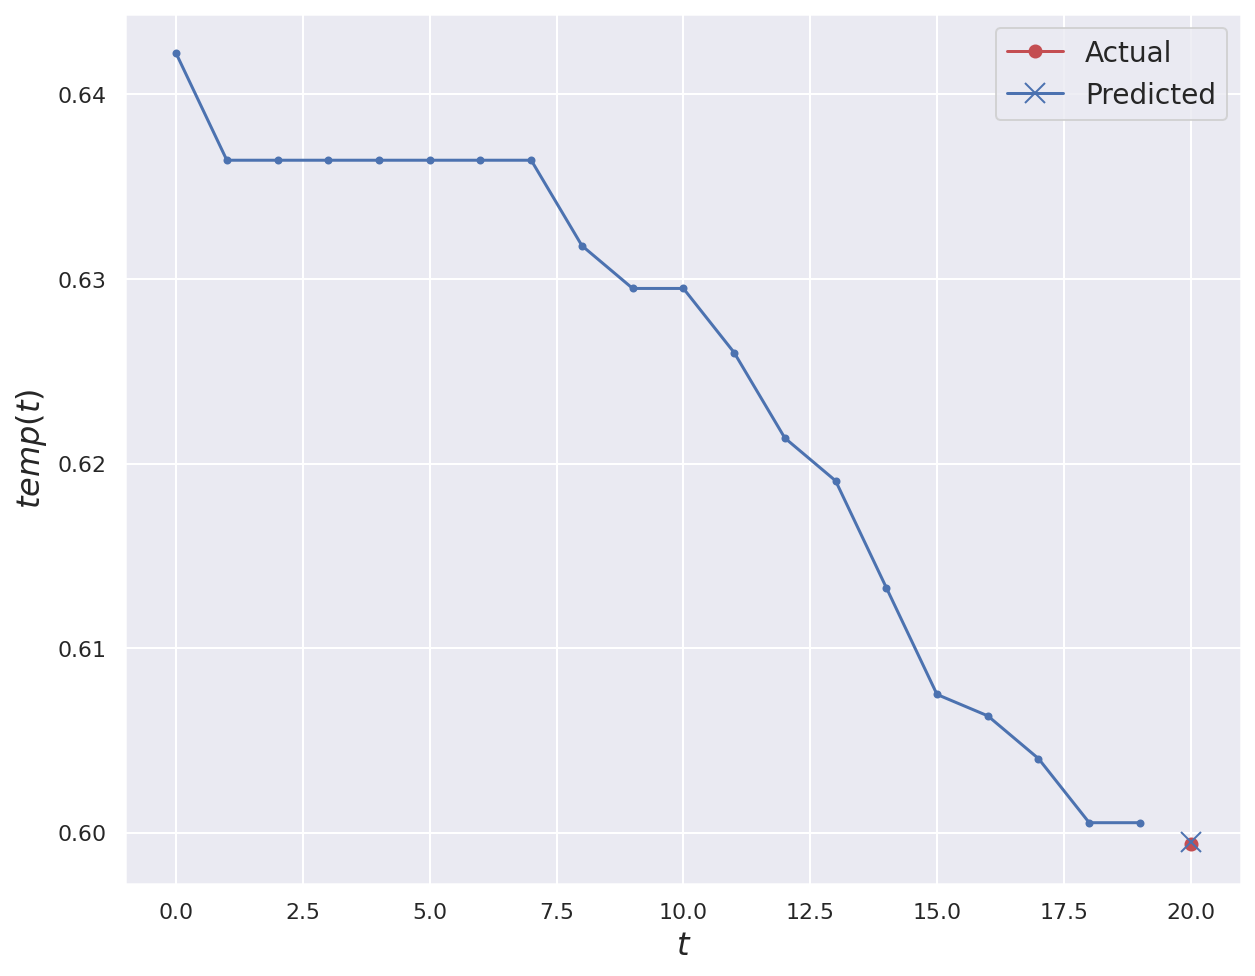

In [32]:
# Plot first validation series with ground truth and prediction
plot_series(series=x_val[0, :, 0], y_true=y_val[0, 0], y_pred=y_pred_univariate[0, 0])
plt.show()